In [1]:
import numpy as np
import ot
import ot.plot
import random

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import ndimage
from skimage.transform import rotate
from skimage.util import img_as_float, random_noise, img_as_ubyte
from skimage.filters import gaussian

import functions.xor_rxor_with_otp_functions as fn
from proglearn.sims import generate_gaussian_parity
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

from joblib import Parallel, delayed

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

In [2]:
def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
    im_sz = int(np.floor(pic.shape[0]*scale))
    pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))

    pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)

    pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
    pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)

    image_aug = rotate(pic_, angle, resize=False)
    #print(image_aug.shape)
    image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]

    return img_as_ubyte(image_aug_)

In [51]:
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
data_x = np.concatenate([X_train, X_test])
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])

In [17]:
def get_data(data_x, data_y):

    idx_1 = np.where(data_y == 0)[0]
    idx_2 = np.where(data_y == 1)[0]
    #idx_3 = np.where(data_y == 2)[0]
    #idx_4 = np.where(data_y == 3)[0]
    
    random.shuffle(idx_1)
    random.shuffle(idx_2)
    
    task1_x = np.concatenate((data_x[idx_1[0:250]], data_x[idx_2[0:250]]))
    task2_x = np.concatenate((data_x[idx_1[250:500]], data_x[idx_2[250:500]]))

    task1_y = np.concatenate((data_y[idx_1[0:250]], data_y[idx_2[0:250]])).ravel()
    task2_y = np.concatenate((data_y[idx_1[250:500]], data_y[idx_2[250:500]])).ravel()
    random.shuffle(task2_y)

    test_x = np.concatenate((data_x[idx_1[500:600]], data_x[idx_2[500:600]]))
    test_y = np.concatenate((data_y[idx_1[500:600]], data_y[idx_2[500:600]])).ravel()
    
    return task1_x, task2_x, task1_y, task2_y, test_x, test_y

In [52]:
idx_1 = np.where(data_y == 0)[0]
idx_2 = np.where(data_y == 1)[0]
    #idx_3 = np.where(data_y == 2)[0]
    #idx_4 = np.where(data_y == 3)[0]

    
task1_x = np.concatenate((data_x[idx_1[0:250]], data_x[idx_2[0:250]]))
task2_x = np.concatenate((data_x[idx_1[250:500]], data_x[idx_2[250:500]]))

task1_y = np.concatenate((data_y[idx_1[0:250]], data_y[idx_2[0:250]])).ravel()
task2_y = np.concatenate((data_y[idx_1[250:500]], data_y[idx_2[250:500]])).ravel()

test_x = np.concatenate((data_x[idx_1[500:600]], data_x[idx_2[500:600]]))
test_y = np.concatenate((data_y[idx_1[500:600]], data_y[idx_2[500:600]])).ravel()

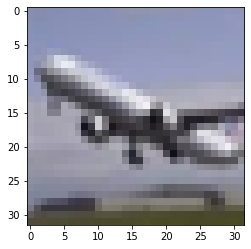

In [24]:
plt.imshow((task2_x[0].reshape(32, 32, 3)))

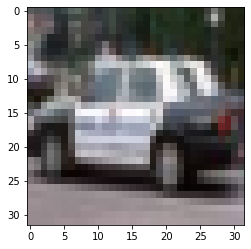

In [25]:
plt.imshow((task1_x[400].reshape(32, 32, 3)))

In [88]:
task1_mean = np.mean(task1_x, axis=0)
task1_std = np.std(task1_x, axis=0)

In [89]:
task1_normalized = (task1_x - task1_mean)/task1_std

In [90]:
from sklearn.utils import shuffle

X, y = shuffle(task1_normalized, task1_y)

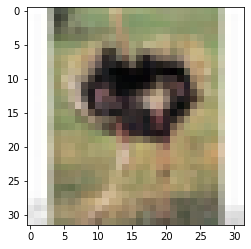

In [74]:
plt.imshow((task1_x[100].reshape(32, 32, 3)))

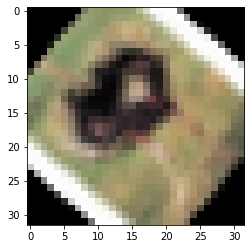

In [75]:
img_rotated = rotate((task1_x[100].reshape(32, 32, 3)), 50)
plt.imshow(img_rotated)

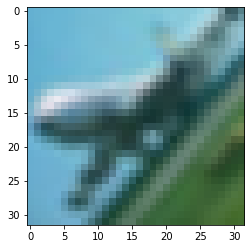

In [53]:
tmp_data = (task1_x[100].reshape(32, 32, 3)).copy()
_tmp_ = np.zeros((32,32,3), dtype=int)
tmp_ = image_aug(tmp_data, 50)
tmp_data = tmp_
plt.imshow(tmp_data)

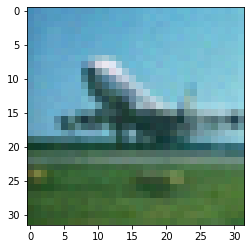

In [27]:
sigma = 0.01
noisy = random_noise((task1_x[100].reshape(32, 32, 3)), var=sigma ** 2)
plt.imshow(noisy)

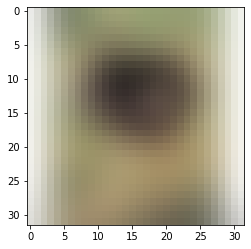

In [78]:
gauss = gaussian((task1_x[100].reshape(32, 32, 3)), sigma=2.5, multichannel=True)
plt.imshow(gauss)

In [43]:
def experiment(rotation_angle=None, noise=None, gauss=None):
    n_trees=10
    max_depth=30

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-2)
    #ot_sinkhorn.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
    #transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=X_task2.copy())
    #X_task2 = transp_Xs_sinkhorn
            
    #ot_lasso = ot.da.SinkhornL1l2Transport(reg_e=0.1, max_iter=30)
    #ot_lasso.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
    #transp_Xs_lasso = ot_lasso.transform(Xs=X_task2.copy())
    #X_task2 = transp_Xs_lasso
    
    task1_x, task2_x, task1_y, task2_y, test_x, test_y = get_data(data_x, data_y)

    progressive_learner.add_task(task1_x, task1_y, num_transformers=n_trees) 
    
    tmp_data = task2_x.copy()
    _tmp_ = np.zeros((32,32,3), dtype=int)
    total_data = tmp_data.shape[0]
    
    if rotation_angle:
        for i in range(total_data):
            tmp_ = image_aug(tmp_data[i].reshape(32, 32, 3), rotation_angle)
            tmp_data[i] = tmp_.reshape(32*32*3)
    
    if noise:
        for i in range(total_data):
            tmp_ = random_noise((tmp_data[i].reshape(32, 32, 3)), var=noise ** 2)
            tmp_data[i] = img_as_ubyte(tmp_.reshape(32*32*3))
    
    if gauss:
        for i in range(total_data):
            tmp_ = gaussian((tmp_data[i].reshape(32, 32, 3)), sigma=gauss, multichannel=True)
            tmp_data[i] = img_as_ubyte(tmp_.reshape(32*32*3))
    
    progressive_learner.add_task(tmp_data, task2_y, num_transformers=n_trees)

    uf_task1 = progressive_learner.predict(test_x, transformer_ids=[0], task_id=0)
    l2f_task1=progressive_learner.predict(test_x, task_id=0)

    errors = np.zeros(2, dtype=float)
    acc_uf = (uf_task1 == test_y).sum()/uf_task1.shape[0]
    acc_l2f = (l2f_task1 == test_y).sum()/l2f_task1.shape[0]
    errors[0] = 1 - acc_uf
    errors[1] = 1 - acc_l2f

    return errors

In [19]:
errors = np.array(Parallel(n_jobs=-1, verbose=1)(delayed(experiment)() for _ in range(20)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   26.4s finished


In [20]:
te = (errors[:,0]/errors[:,1]).sum()/errors.shape[0]
print("average TE with no data transformation: " + str(te))

average TE with no data transformation: 1.064917373315206


In [91]:
errors = np.array(Parallel(n_jobs=-1, verbose=1)(delayed(experiment)() for _ in range(20)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   56.6s finished


In [92]:
te = (errors[:,0]/errors[:,1]).sum()/errors.shape[0]
print("average TE with flipped labels: " + str(te))

average TE with flipped labels: 0.9861697530708204


In [8]:
angle_sweep = np.arange(0, 91, 10)

In [9]:
mean_te1 = np.zeros(len(angle_sweep), dtype=float)
gen_error1 = []

for ii, angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                rotation_angle = angle
            )
            for _ in range(50)
        )
    )
    gen_error1.append((np.mean(error[:,0]), np.mean(error[:, 1])))
    mean_te1[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Don

In [44]:
noise_sweep = np.arange(0, 0.011, 0.002)
noise_sweep

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 ])

In [45]:
mean_te2 = np.zeros(len(noise_sweep), dtype=float)
gen_error2 = []

for ii, sigma in enumerate(noise_sweep):
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                noise = sigma
            )
            for _ in range(50)
        )
    )
    
    gen_error2.append((np.mean(error[:,0]), np.mean(error[:, 1])))
    mean_te2[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Don

In [64]:
gauss_sweep = np.arange(0, 2.6, 0.5)

In [67]:
mean_te3 = np.zeros(len(gauss_sweep), dtype=float)
gen_error3 = []

for ii, sigma in enumerate(gauss_sweep):
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                gauss = sigma
            )
            for _ in range(20)
        )
    )
    
    gen_error3.append((np.mean(error[:, 0]), np.mean(error[:, 1])))
    mean_te3[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   55.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   28.2s finished


In [10]:
print(gen_error1)

[(0.23620000000000005, 0.2187), (0.2421, 0.22970000000000002), (0.23929999999999998, 0.22639999999999996), (0.24, 0.22390000000000002), (0.24389999999999998, 0.23129999999999998), (0.24049999999999996, 0.23049999999999998), (0.2412, 0.22719999999999996), (0.24459999999999993, 0.23089999999999997), (0.23309999999999995, 0.2232), (0.23739999999999994, 0.2296)]


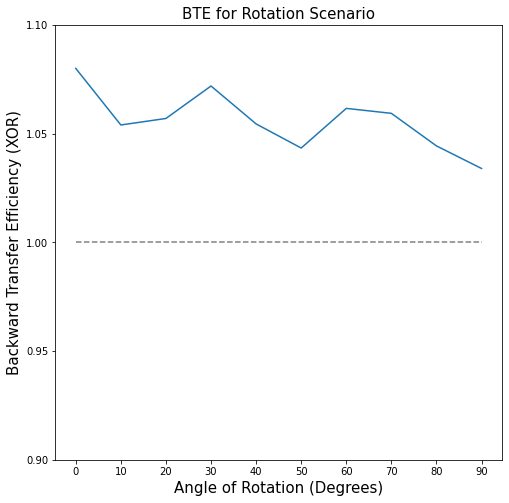

In [11]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(angle_sweep, mean_te1)
ax.set_xticks(range(0, 91, 10))
ax.tick_params(labelsize=10)
ax.set_title("BTE for Rotation Scenario", fontsize=15)
ax.set_xlabel("Angle of Rotation (Degrees)", fontsize=15)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=15)
ax.hlines(1, 0, 90, colors="grey", linestyles="dashed", linewidth=1.5)
ax.set_yticks([0.9, 0.95, 1, 1.05, 1.1])

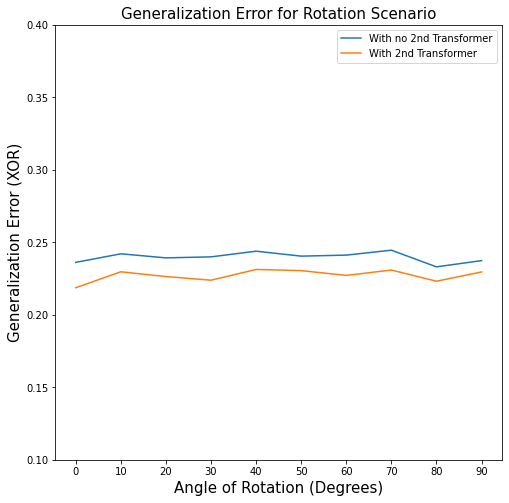

In [12]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(angle_sweep, np.array(gen_error1)[:,0])
ax.plot(angle_sweep, np.array(gen_error1)[:,1])
ax.set_xticks(range(0, 91, 10))
ax.tick_params(labelsize=10)
ax.set_title("Generalization Error for Rotation Scenario", fontsize=15)
ax.set_xlabel("Angle of Rotation (Degrees)", fontsize=15)
ax.set_ylabel("Generalization Error (XOR)", fontsize=15)
ax.set_yticks(np.arange(0.1, 0.41, 0.05))
ax.legend(['With no 2nd Transformer', 'With 2nd Transformer'])

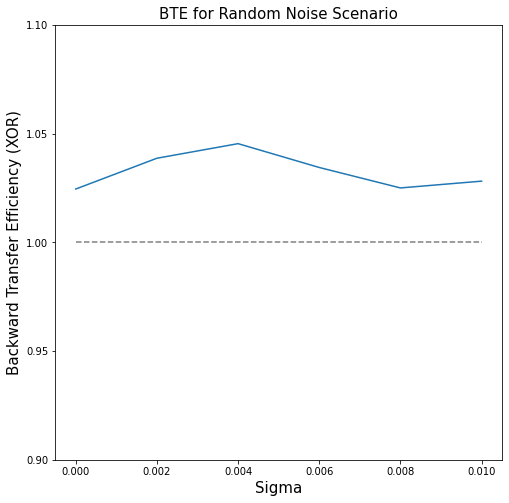

In [47]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(noise_sweep, mean_te2)
ax.tick_params(labelsize=10)
ax.set_title("BTE for Random Noise Scenario", fontsize=15)
ax.set_xlabel("Sigma", fontsize=15)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=15)
ax.hlines(1, 0, 0.01, colors="grey", linestyles="dashed", linewidth=1.5)
ax.set_xticks(np.arange(0, 0.011, 0.002))
ax.set_yticks([0.9, 0.95, 1, 1.05, 1.1])

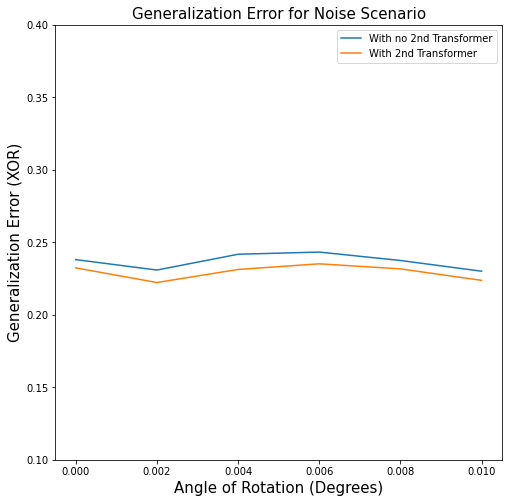

In [50]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(noise_sweep, np.array(gen_error2)[:,0])
ax.plot(noise_sweep, np.array(gen_error2)[:,1])
ax.set_xticks(np.arange(0, 0.011, 0.002))
ax.tick_params(labelsize=10)
ax.set_title("Generalization Error for Noise Scenario", fontsize=15)
ax.set_xlabel("Angle of Rotation (Degrees)", fontsize=15)
ax.set_ylabel("Generalization Error (XOR)", fontsize=15)
ax.set_yticks(np.arange(0.1, 0.41, 0.05))
ax.legend(['With no 2nd Transformer', 'With 2nd Transformer'])

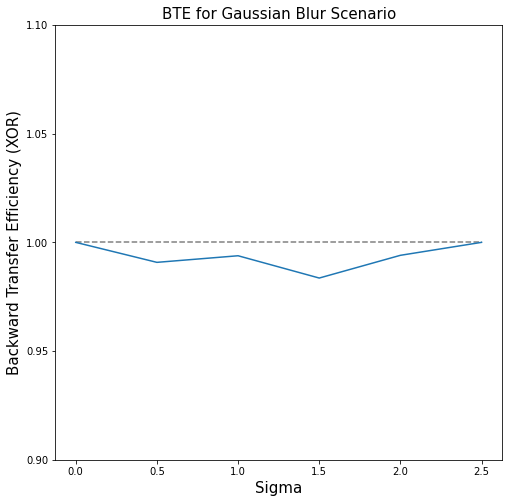

In [100]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(gauss_sweep, mean_te3)
ax.tick_params(labelsize=10)
ax.set_xlabel("Sigma", fontsize=15)
ax.set_title("BTE for Gaussian Blur Scenario", fontsize=15)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=15)
ax.hlines(1, 0, 2.5, colors="grey", linestyles="dashed", linewidth=1.5)
ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_yticks([0.9, 0.95, 1, 1.05, 1.1])

In [35]:
n_trees=20
max_depth=30
noise = 0.01
#rotation_angle = 90
#gauss = 1

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}

default_decider_class = SimpleArgmaxAverage
default_decider_kwargs = {"classes": np.arange(2)}
progressive_learner = ProgressiveLearner(
    default_transformer_class=default_transformer_class,
    default_transformer_kwargs=default_transformer_kwargs,
    default_voter_class=default_voter_class,
    default_voter_kwargs=default_voter_kwargs,
    default_decider_class=default_decider_class,
    default_decider_kwargs=default_decider_kwargs,
)

task1_x, task2_x, task1_y, task2_y, test_x, test_y = get_data(data_x, data_y)

progressive_learner.add_task(task1_x, task1_y, num_transformers=n_trees) 
    
tmp_data = task2_x.copy()
_tmp_ = np.zeros((32,32,3), dtype=int)
total_data = tmp_data.shape[0]
    
#if rotation_angle:
#    for i in range(total_data):
#        tmp_ = image_aug(tmp_data[i].reshape(32, 32, 3), rotation_angle)
#        tmp_data[i] = tmp_.reshape(32*32*3)
    
if noise:
    for i in range(total_data):
        tmp = random_noise((tmp_data[i].reshape(32, 32, 3)), var=noise ** 2)
        tmp_data[i] = tmp.reshape(32*32*3)
    
#if gauss:
#    for i in range(total_data):
#        tmp = gaussian((tmp_data[i].reshape(32, 32, 3)), sigma=gauss, multichannel=True)
#        tmp_data[i] = tmp.reshape(32*32*3)
    
progressive_learner.add_task(tmp_data, task2_y, num_transformers=n_trees)

#progressive_learner.add_task(task2_x, task2_y, num_transformers=n_trees)

uf_task1 = progressive_learner.predict(test_x, transformer_ids=[0], task_id=0)
l2f_task1=progressive_learner.predict(test_x, task_id=0)

leaf_nodes_0 = []
leaf_nodes_1 = []
vote_per_transformer_id = []
for transformer_id in progressive_learner.task_id_to_decider[0].transformer_id_to_voters.keys():
    vote_per_bag_id = []
    for bag_id in range(len(progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id])):
        transformer = progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id][bag_id]
        X_transformed = transformer.transform(test_x)
        if transformer_id == 0:
            leaf_nodes_0.append(X_transformed)
        if transformer_id == 1:
            leaf_nodes_1.append(X_transformed)
        voter = progressive_learner.task_id_to_decider[0].transformer_id_to_voters[transformer_id][bag_id]
        vote = voter.predict_proba(X_transformed)
        vote_per_bag_id.append(vote)
    vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

errors = np.zeros(2, dtype=float)
acc_uf = (uf_task1 == test_y).sum()/uf_task1.shape[0]
acc_l2f = (l2f_task1 == test_y).sum()/l2f_task1.shape[0]
errors[0] = 1 - acc_uf
errors[1] = 1 - acc_l2f


In [39]:
errors

array([0.245, 0.245])

In [ ]:
vote_per_transformer_id

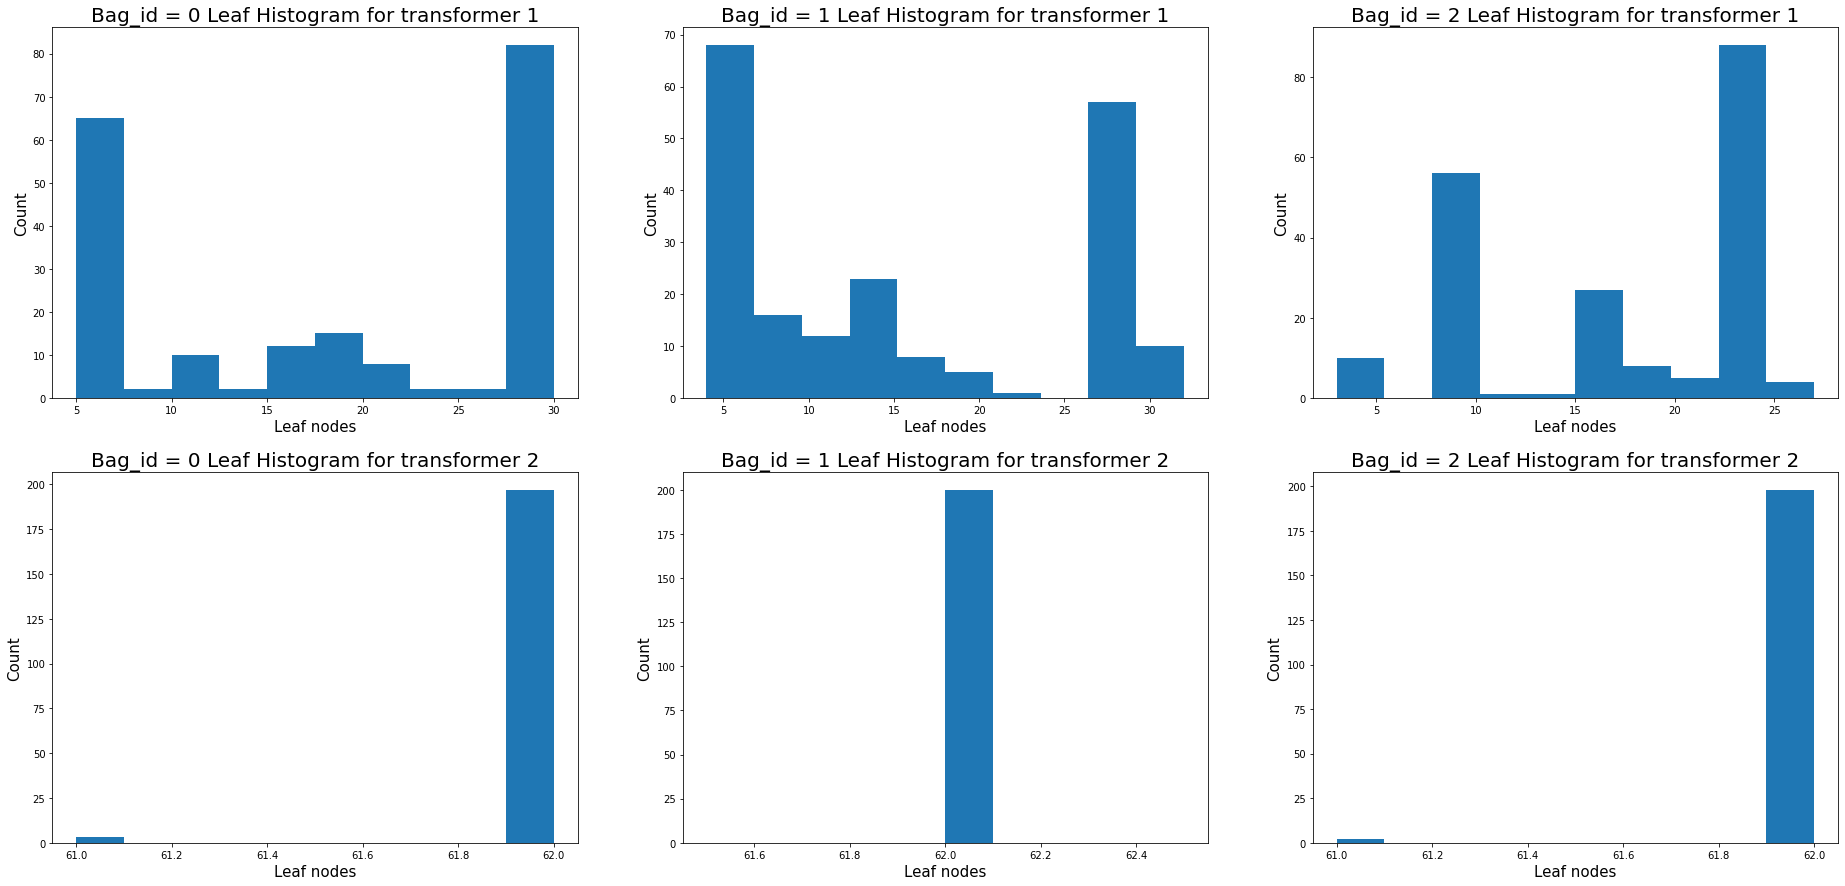

In [40]:
r = 2
c = 3
plt.figure(figsize=(32,15))

for i in range(c):
    ax = plt.subplot(r, c, i+1)
    ax.hist(leaf_nodes_0[i])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 1', fontsize=20)
    ax.set_xlabel('Leaf nodes',fontsize=15)
    ax.set_ylabel('Count',fontsize=15)
    
for i in range(c):
    ax = plt.subplot(r, c, i+4)
    ax.hist(leaf_nodes_1[i])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 2', fontsize=20)
    ax.set_xlabel('Leaf nodes',fontsize=15)
    ax.set_ylabel('Count',fontsize=15)

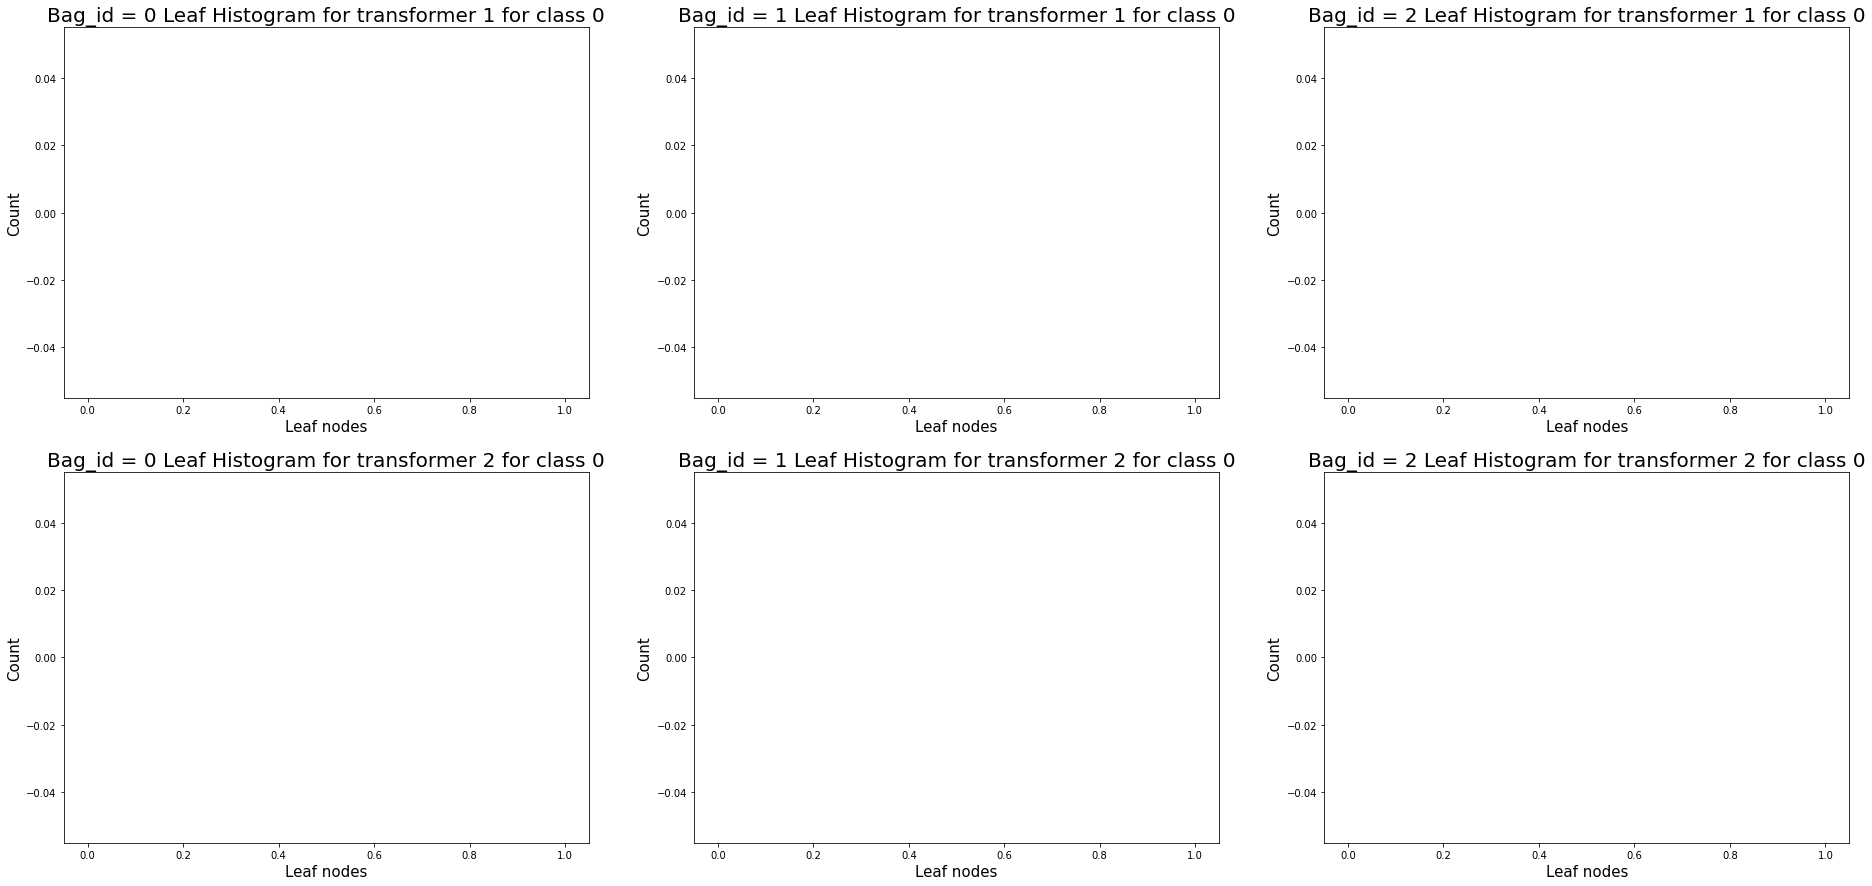

In [37]:
r = 2
c = 3
plt.figure(figsize=(32,15))

for i in range(c):
    ax = plt.subplot(r, c, i+1)
    ax.hist(leaf_nodes_0[i][test_y == 2])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 1 for class 0', fontsize=20)
    ax.set_xlabel('Leaf nodes',fontsize=15)
    ax.set_ylabel('Count',fontsize=15)
    
for i in range(c):
    ax = plt.subplot(r, c, i+4)
    ax.hist(leaf_nodes_1[i][test_y == 2])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 2 for class 0', fontsize=20)
    ax.set_xlabel('Leaf nodes',fontsize=15)
    ax.set_ylabel('Count',fontsize=15)

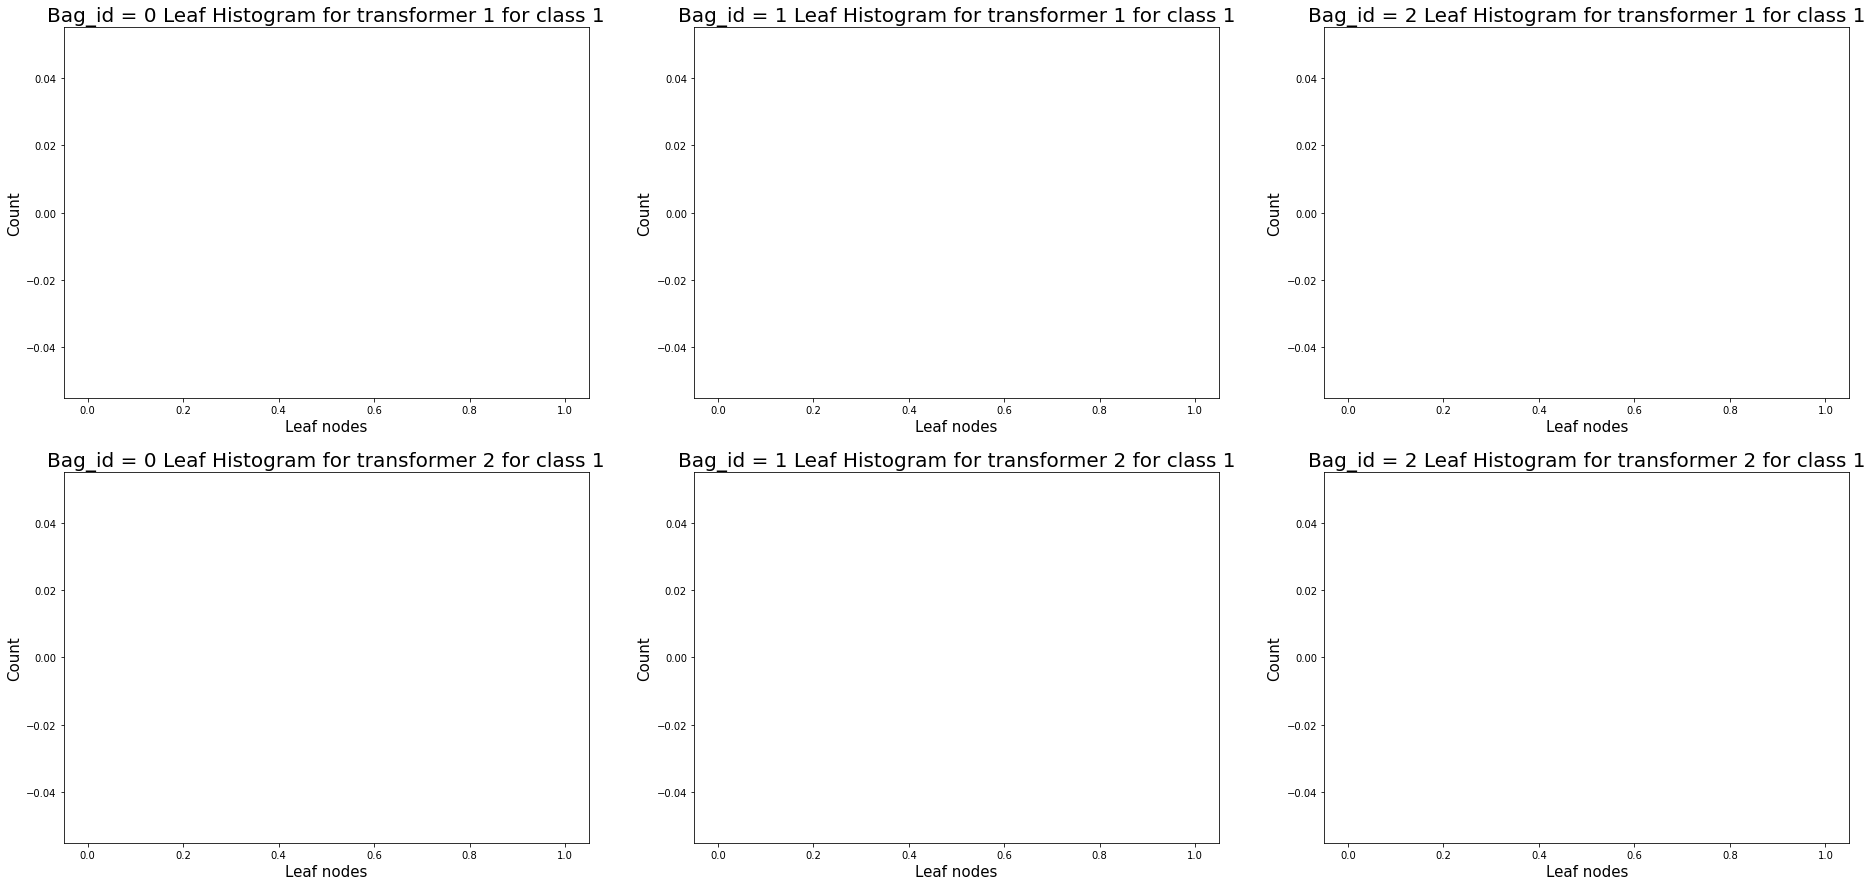

In [38]:
r = 2
c = 3
plt.figure(figsize=(32,15))

for i in range(c):
    ax = plt.subplot(r, c, i+1)
    ax.hist(leaf_nodes_0[i][test_y == 3])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 1 for class 1', fontsize=20)
    ax.set_xlabel('Leaf nodes',fontsize=15)
    ax.set_ylabel('Count',fontsize=15)
    
for i in range(c):
    ax = plt.subplot(r, c, i+4)
    ax.hist(leaf_nodes_1[i][test_y == 3])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 2 for class 1', fontsize=20)
    ax.set_xlabel('Leaf nodes',fontsize=15)
    ax.set_ylabel('Count',fontsize=15)